# Run BADASS for NucB

#### Installs and imports

In [3]:
# Load packages and define ref_seq for Mut321
%run setup_environment.py
import seq2fitness_models as models
import protein_optimizer
import seq2fitness_traintools as traintools
import seq2fitness_train as train
#import evo_prot_grad
#import seq2fitness_expert
#import evo_prot_grad.common.sampler as sampler
import os
import pickle
import time
import gc
import joblib
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)

import torch
import esm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Paths added to sys.path:
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/data
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/representation
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/representation/prep
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/utils
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/end_to_end_models
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/training
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/mld
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/mld/libdesign
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/inference
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/models
/home/ubuntu/DEML-Virginia/NucB-training/DEML/EvoProtGrad/evo_prot_grad
/home/ubuntu/DEML-Virginia/NucB-training/DEML/EvoProtGrad/evo_prot_grad/experts


<module 'seq2fitness_protein_optimizer' from '/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/mld/seq2fitness_protein_optimizer.py'>

## First ESM Only

#### K=6

In [11]:
NUM_MUT = 6
THRESHOLD = 35

esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only
model_params = {
    'ref_seq': ref_seq_nucb, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}
optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter':200, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': THRESHOLD,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}


# Load from the pickle file
'''
with open('single_mutant_scores_amylase_esm_only.pkl', 'rb') as file:
    initial_score_matrix = pickle.load(file)
'''

# Optimizer
optimizer = protein_optimizer.ProteinOptimizer(
    optimizer_params, 
    model_params=model_params, 
    esm_only=True,
    score_matrix=None,
    simple_simulated_annealing=False, 
    cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score 0.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: 2.0512, std dev: 3.8585. To normalize scores.
phase transition threshold is 35


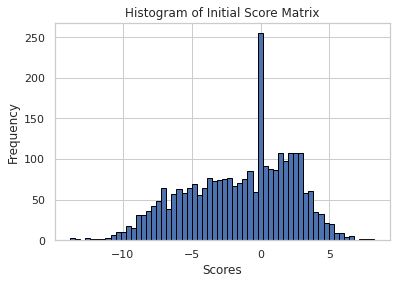

In [12]:
import matplotlib.pyplot as plt

# Assuming initial_score_matrix is already defined and is a NumPy array
# Flatten the matrix to get a 1D array
flattened_scores = initial_score_matrix.flatten()

# Plot the histogram with 60 bins
plt.hist(flattened_scores, bins=60, edgecolor='black')

# Add title and labels
plt.title('Histogram of Initial Score Matrix')
plt.xlabel('Scores')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 1.92e+03 effective entries: 108 sites, 18.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of 2.55, and std. dev. 7.83.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 1.23e+03 effective entries: 95.4 sites, 18.4 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 5.84, and std. dev. 7.36.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 1.12e+03 effective entries: 91.5 sites, 18 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 7.4, and std. dev. 7.26.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 1.04e+0

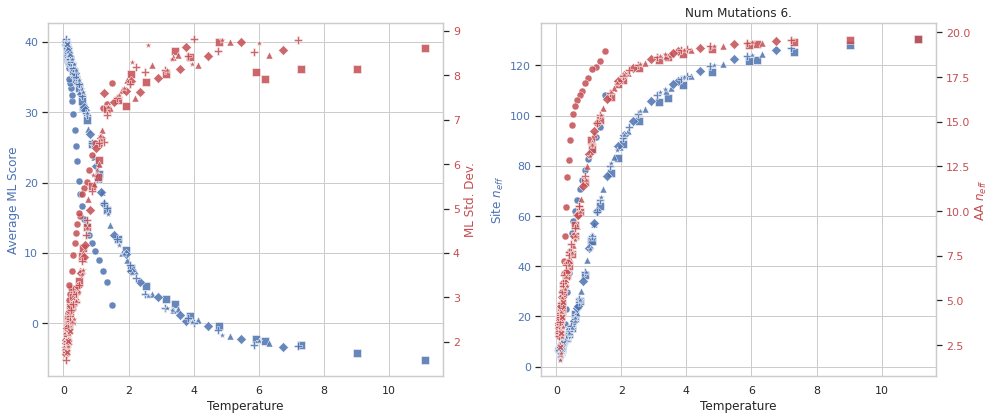

22
22


In [17]:
optimizer.plot_scores()

In [18]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_esm_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

In [19]:
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
torch.cuda.empty_cache()
gc.collect()

Elapsed time: 306.37 seconds


42220

#### K=5

In [20]:
NUM_MUT = 5
THRESHOLD = 30

esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only
model_params = {
    'ref_seq': ref_seq_nucb, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}
optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter':200, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': THRESHOLD,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}


# Load from the pickle file
'''
with open('single_mutant_scores_amylase_esm_only.pkl', 'rb') as file:
    initial_score_matrix = pickle.load(file)
'''

# Optimizer
optimizer = protein_optimizer.ProteinOptimizer(
    optimizer_params, 
    model_params=model_params, 
    esm_only=True,
    score_matrix=None,
    simple_simulated_annealing=False, 
    cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score 0.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: 2.0512, std dev: 3.8585. To normalize scores.
phase transition threshold is 30


In [21]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 1.92e+03 effective entries: 108 sites, 18.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of 2.03, and std. dev. 7.21.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 1.33e+03 effective entries: 95.3 sites, 18.2 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 4.26, and std. dev. 6.84.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 1.21e+03 effective entries: 92.2 sites, 18.1 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 5.93, and std. dev. 6.48.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 1.12

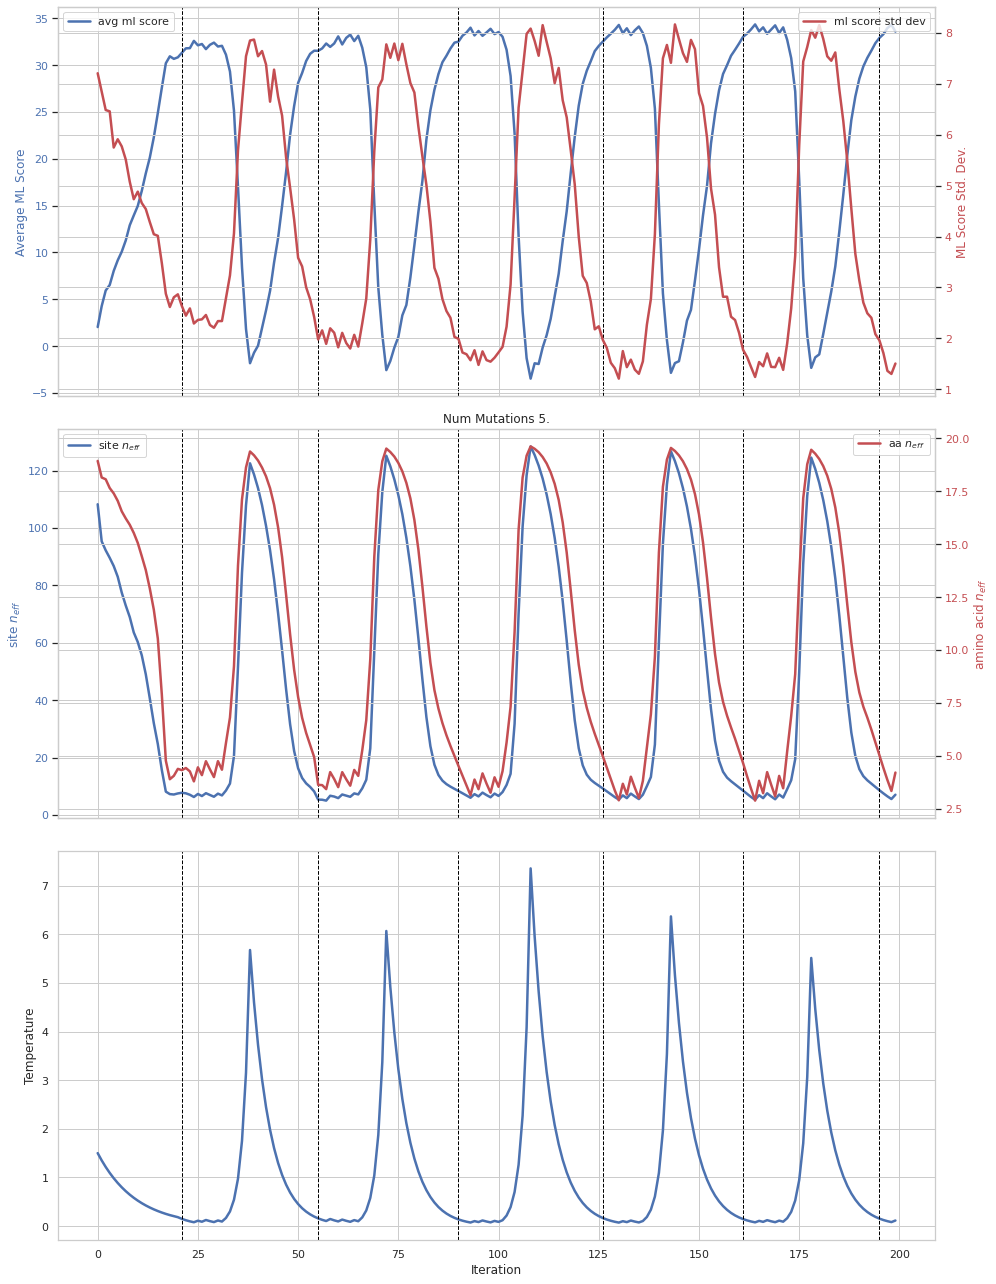

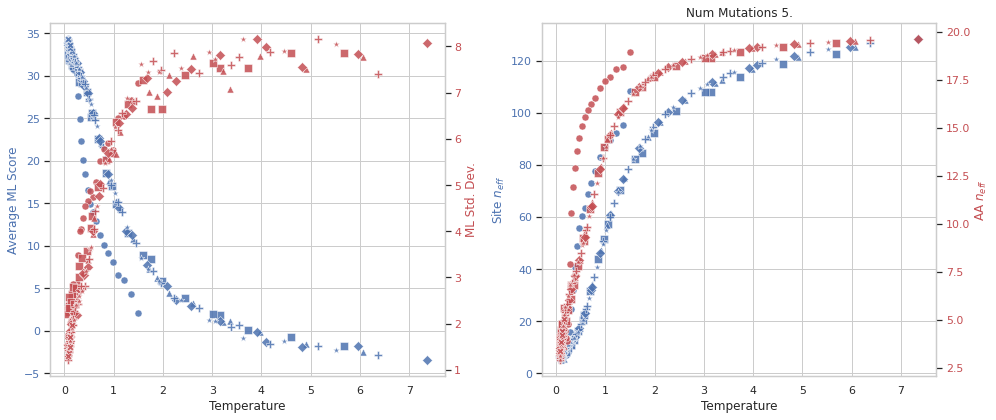

20
20


In [22]:
optimizer.plot_scores()

In [23]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_esm_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=4

In [26]:
NUM_MUT = 4
THRESHOLD = 25
NUM_ITER = 200

esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only
model_params = {
    'ref_seq': ref_seq_nucb, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}
optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter': NUM_ITER, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': THRESHOLD,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}


# Load from the pickle file
'''
with open('single_mutant_scores_amylase_esm_only.pkl', 'rb') as file:
    initial_score_matrix = pickle.load(file)
'''

# Optimizer
optimizer = protein_optimizer.ProteinOptimizer(
    optimizer_params, 
    model_params=model_params, 
    esm_only=True,
    score_matrix=None,
    simple_simulated_annealing=False, 
    cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score 0.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: 2.0512, std dev: 3.8585. To normalize scores.
phase transition threshold is 25


In [ ]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 1.92e+03 effective entries: 108 sites, 18.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of 1.66, and std. dev. 6.35.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 1.45e+03 effective entries: 97.6 sites, 18.4 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 3.77, and std. dev. 6.1.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 1.3e+03 effective entries: 92.5 sites, 18.1 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 4.58, and std. dev. 6.19.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 1.19e+

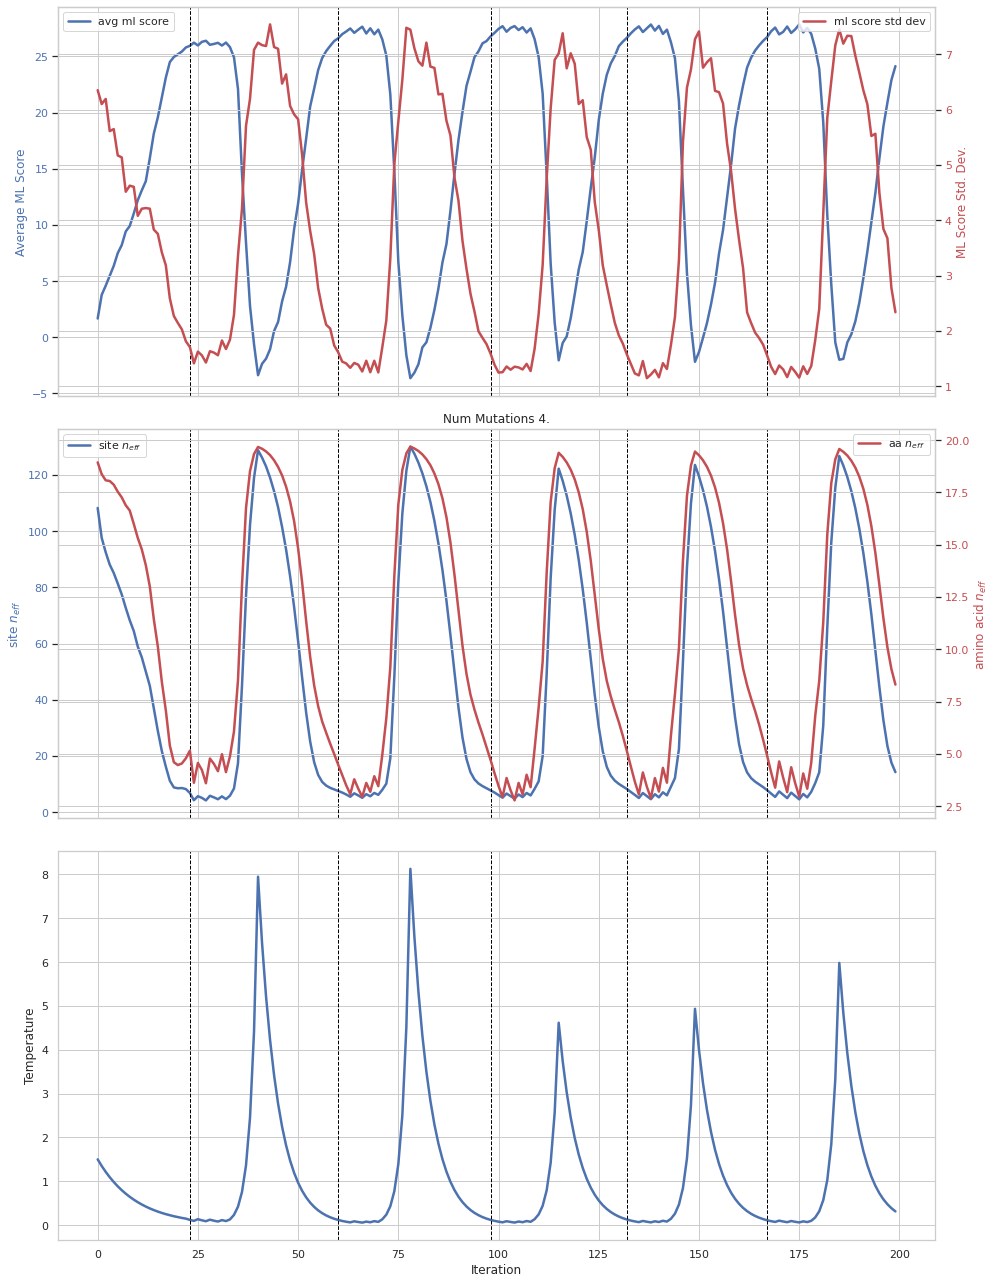

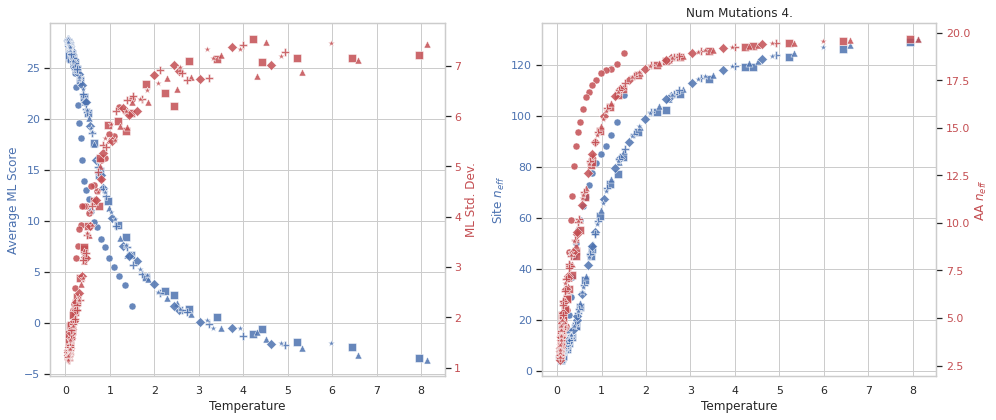

22
22


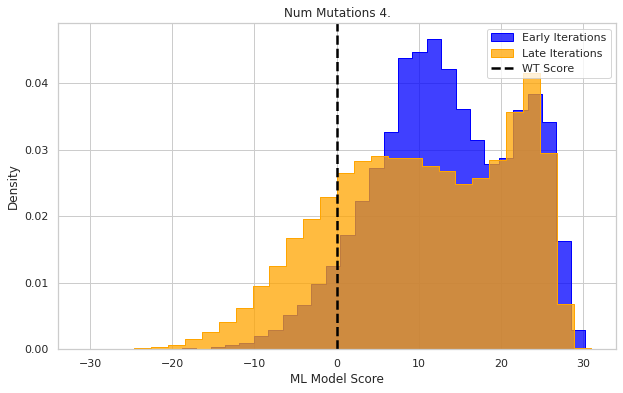

In [28]:
optimizer.plot_scores()

In [29]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_esm_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=3

In [30]:
NUM_MUT = 3
THRESHOLD = 18
NUM_ITER = 200

esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only
model_params = {
    'ref_seq': ref_seq_nucb, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}
optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter': NUM_ITER, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': THRESHOLD,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}


# Load from the pickle file
'''
with open('single_mutant_scores_amylase_esm_only.pkl', 'rb') as file:
    initial_score_matrix = pickle.load(file)
'''

# Optimizer
optimizer = protein_optimizer.ProteinOptimizer(
    optimizer_params, 
    model_params=model_params, 
    esm_only=True,
    score_matrix=None,
    simple_simulated_annealing=False, 
    cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score 0.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: 2.0512, std dev: 3.8585. To normalize scores.
phase transition threshold is 18


In [ ]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 1.92e+03 effective entries: 108 sites, 18.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of 1.19, and std. dev. 5.68.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 1.59e+03 effective entries: 99.7 sites, 18.4 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 2.08, and std. dev. 5.29.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 1.45e+03 effective entries: 95 sites, 18.4 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 2.22, and std. dev. 5.5.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 1.33e+0

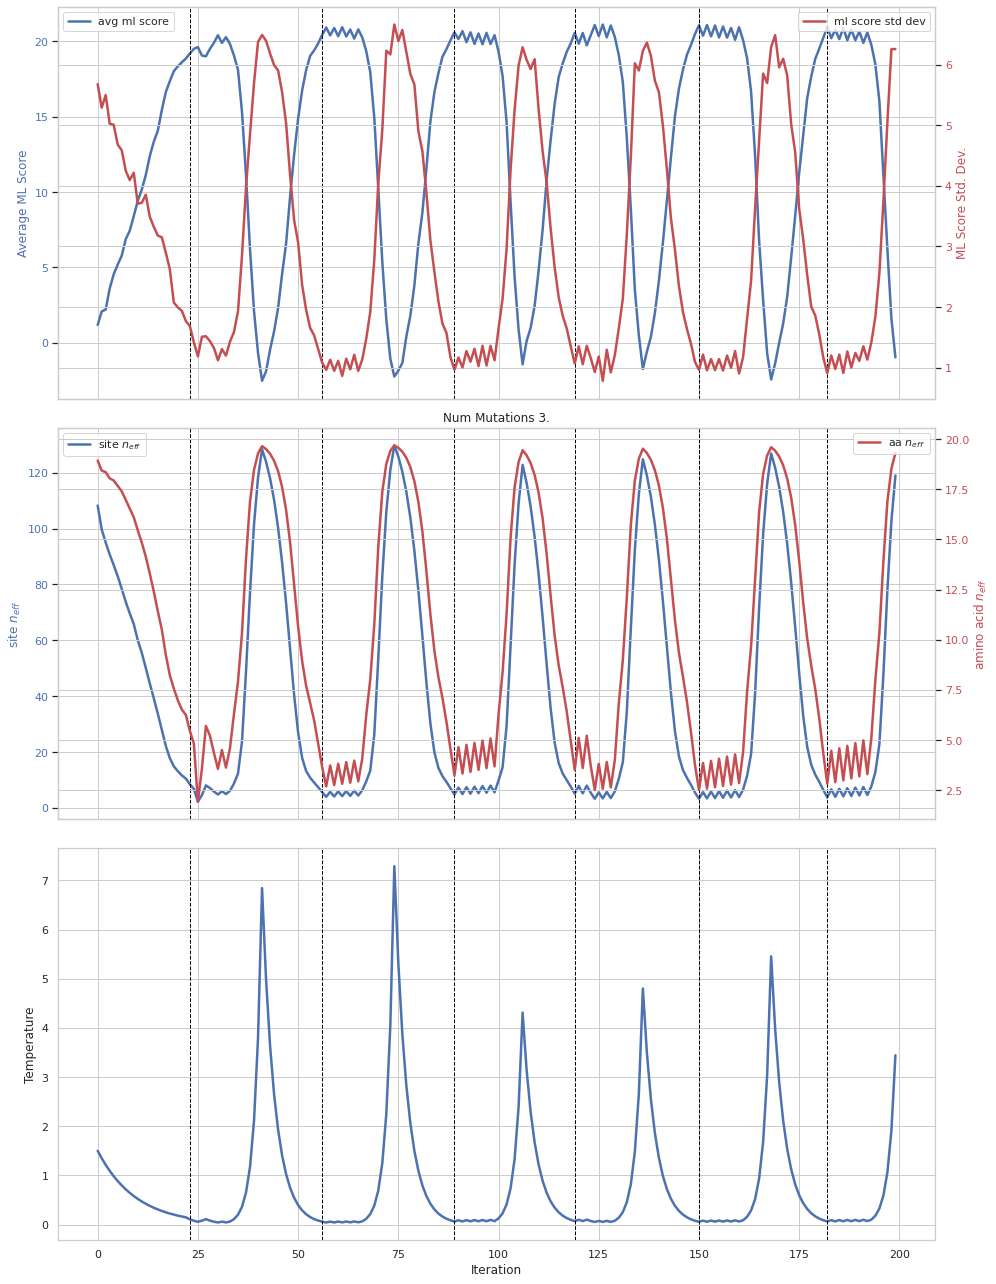

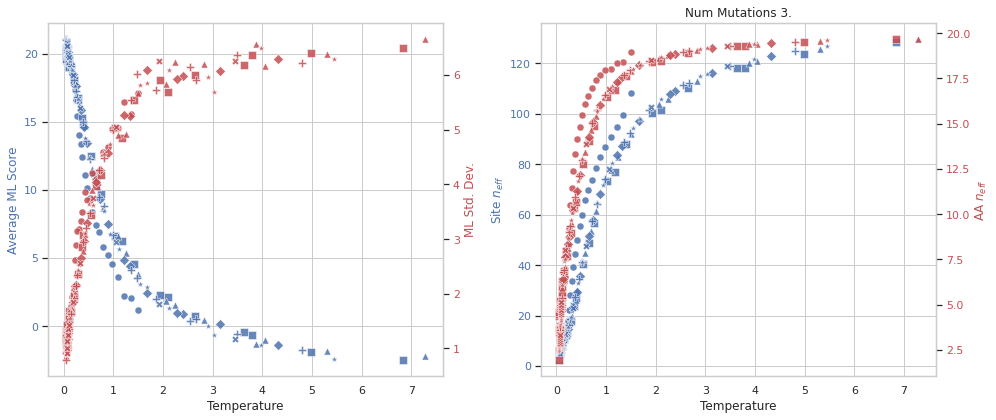

22
22


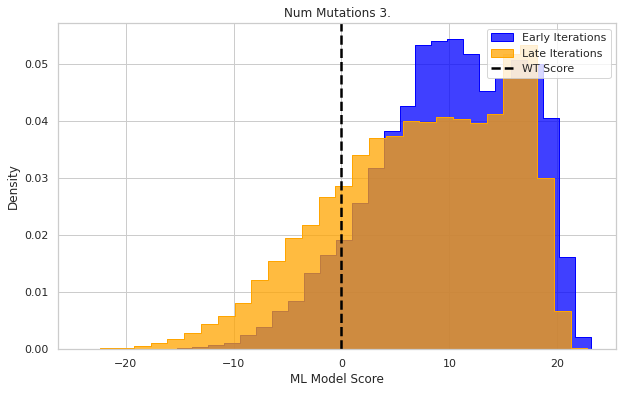

In [34]:
optimizer.plot_scores()

In [35]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_esm_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=2

In [ ]:
NUM_MUT = 2
THRESHOLD = 12
NUM_ITER = 200

esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only
model_params = {
    'ref_seq': ref_seq_nucb, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}
optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter': NUM_ITER, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': THRESHOLD,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}


# Load from the pickle file
'''
with open('single_mutant_scores_amylase_esm_only.pkl', 'rb') as file:
    initial_score_matrix = pickle.load(file)
'''

# Optimizer
import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(
    optimizer_params, 
    model_params=model_params, 
    esm_only=True,
    score_matrix=None,
    simple_simulated_annealing=False, 
    cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")

In [ ]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 1.92e+03 effective entries: 108 sites, 18.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of 0.86, and std. dev. 4.74.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 1.73e+03 effective entries: 102 sites, 18.6 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 1.37, and std. dev. 4.57.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 1.6e+03 effective entries: 97.8 sites, 18.5 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 1.81, and std. dev. 4.68.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 1.47e+

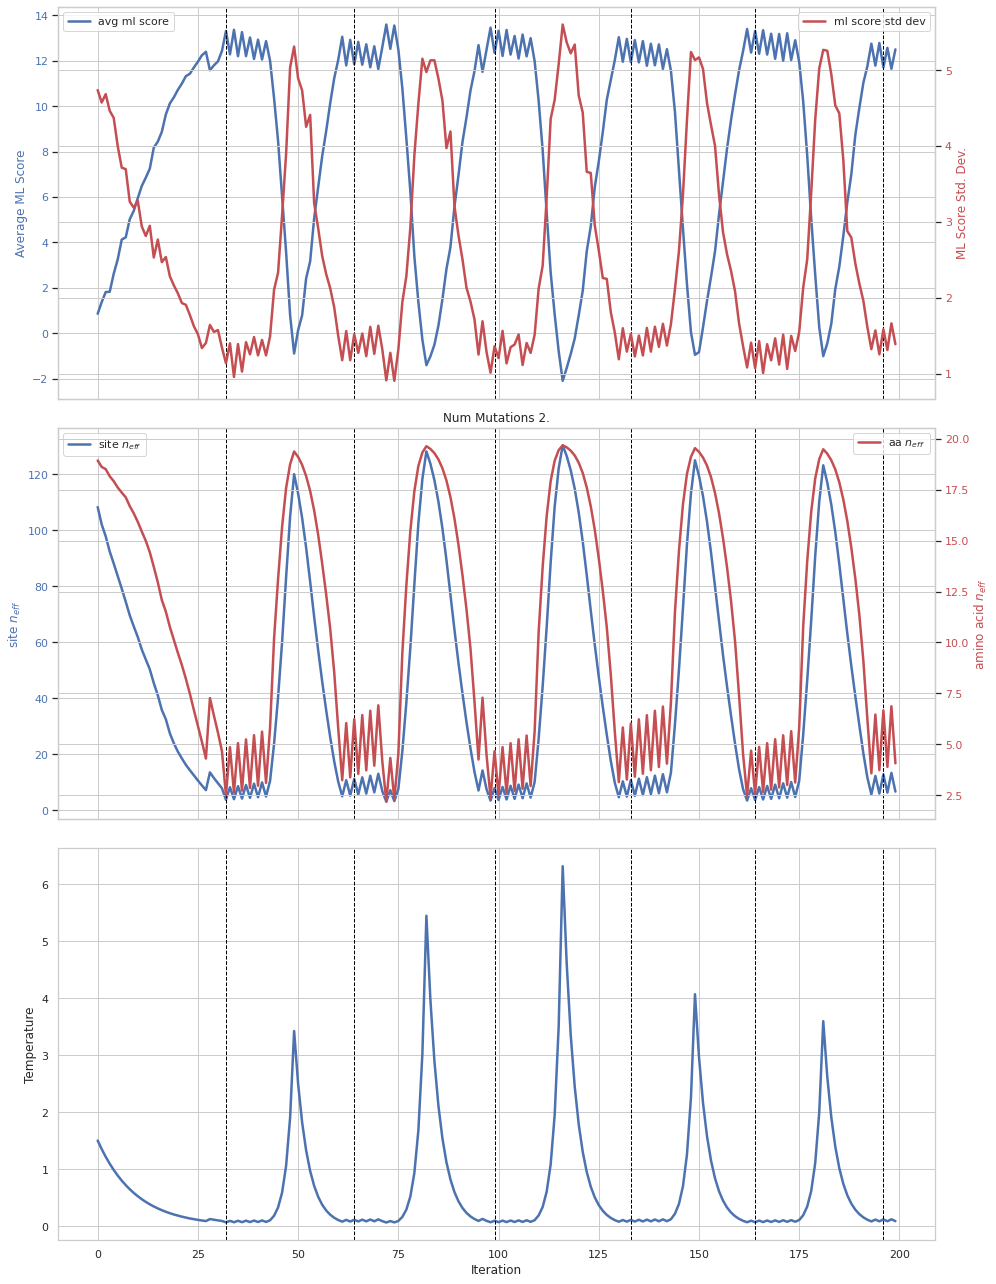

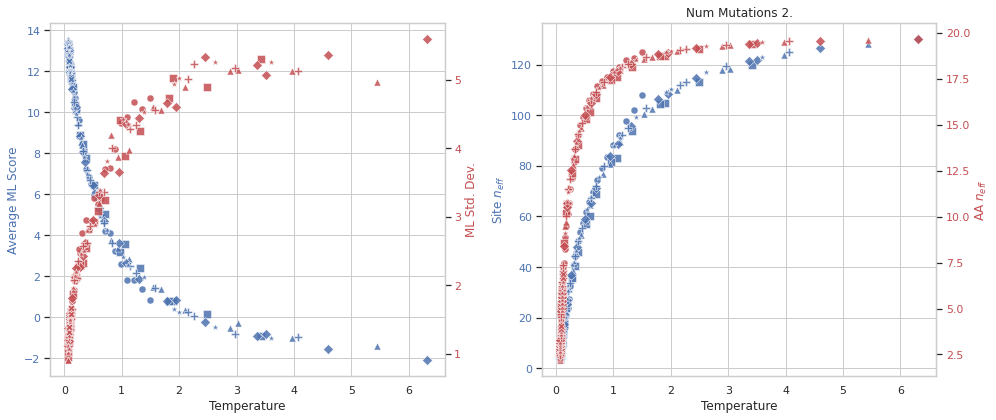

31
31


In [40]:
optimizer.plot_scores()

In [41]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_esm_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=2to6

In [55]:
NUM_MUT = 6
THRESHOLD = 22
NUM_ITER = 200

esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only
model_params = {
    'ref_seq': ref_seq_nucb, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}
optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter': NUM_ITER, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': THRESHOLD,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1], # known bad sites that we should not sample sequences from
    'sample_variety_of_mutation_numbers': True
}


# Load from the pickle file
'''
with open('single_mutant_scores_amylase_esm_only.pkl', 'rb') as file:
    initial_score_matrix = pickle.load(file)
'''

# Optimizer
import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)

optimizer = protein_optimizer.ProteinOptimizer(
    optimizer_params, 
    model_params=model_params, 
    esm_only=True,
    score_matrix=None,
    simple_simulated_annealing=False, 
    cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score 0.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: 2.0512, std dev: 3.8585. To normalize scores.
phase transition threshold is 22


In [ ]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 1.92e+03 effective entries: 108 sites, 18.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of 1.72, and std. dev. 6.58.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 1.29e+03 effective entries: 90.8 sites, 17.9 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 4.33, and std. dev. 5.99.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 1.19e+03 effective entries: 90.5 sites, 18 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 4.34, and std. dev. 6.37.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 1.1e+0

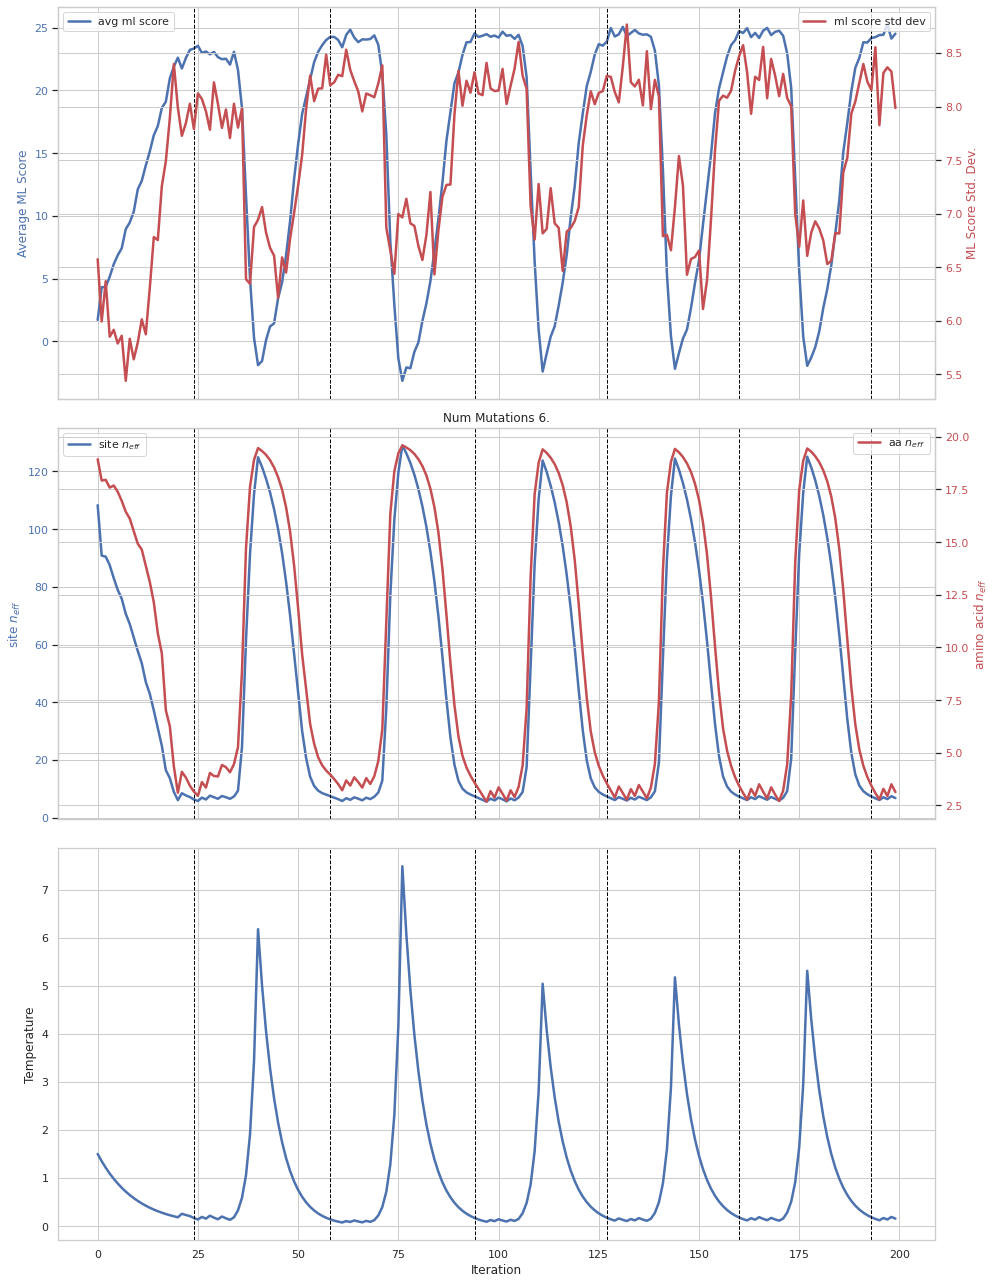

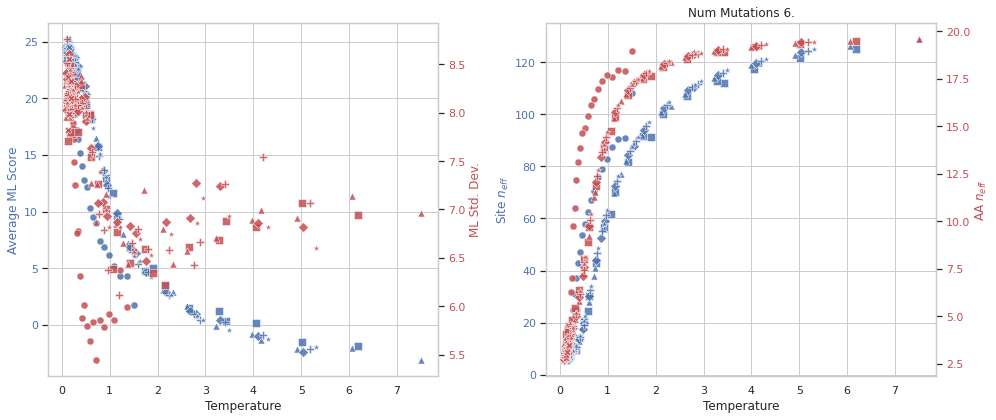

23
23


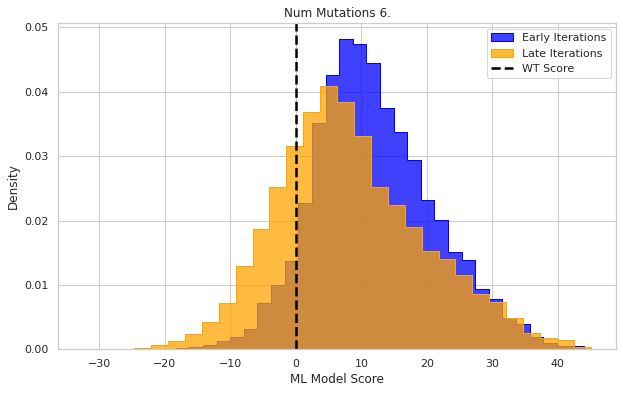

In [58]:
optimizer.plot_scores()

In [59]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_esm_results_num_mutations_2to6_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

There were 52242 unique sequences found.
Best Sequence:
W5T-H8A-G22P-Y25A-G51A-E69D
Best Score: 44.9961
Percentiles:
  25th Percentile: 1.6071
  50th Percentile: 7.9658
  75th Percentile: 15.9570
  90th Percentile: 24.3242
  99th Percentile: 36.3991


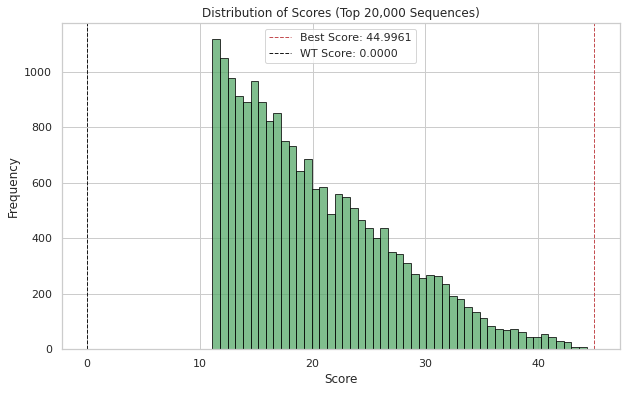

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded with the given structure

# Compute the percentiles
percentiles = np.percentile(df['ml_score'], [25, 50, 75, 90, 99])

# Find the best sequence and its score
best_score = df['ml_score'].max()
best_sequence = df.loc[df['ml_score'].idxmax(), 'sequences']

# Print the unique sequences found
print(f"There were {len(set(df['sequences']))} unique sequences found.")

# Print the best sequence and its score
print(f"Best Sequence:")
print(best_sequence)

print(f"Best Score: {best_score:.4f}")

# Print the percentiles
print(f"Percentiles:")
print(f"  25th Percentile: {percentiles[0]:.4f}")
print(f"  50th Percentile: {percentiles[1]:.4f}")
print(f"  75th Percentile: {percentiles[2]:.4f}")
print(f"  90th Percentile: {percentiles[3]:.4f}")
print(f"  99th Percentile: {percentiles[4]:.4f}")

# Plotting the percentiles
#plt.figure(figsize=(10, 6))
#plt.plot([25, 50, 75, 90, 99], percentiles, marker='o', linestyle='--', color='b')
#plt.xlabel('Percentile')
#plt.ylabel('Score')
#plt.title('Percentiles of Scores')
#plt.grid(True)
#plt.show()

# Plot the score distribution of the top 10,000 sequences
top_n = 20000
top_10000_df = df.nlargest(top_n, 'ml_score')

plt.figure(figsize=(10, 6))
plt.hist(top_10000_df['ml_score'], bins=50, alpha=0.75, color='g', edgecolor='black')
plt.axvline(best_score, color='r', linestyle='dashed', linewidth=1, label=f'Best Score: {best_score:.4f}')
plt.axvline(optimizer.wt_score, color='k', linestyle='dashed', linewidth=1, label=f'WT Score: {float(optimizer.wt_score):.4f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scores (Top {top_n:,} Sequences)')
plt.legend()
plt.grid(True)
plt.show()

## Now Optimize ML Model Scores

#### K=6

In [23]:
NUM_MUT = 6
NUM_ITER = 200


model_path = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': 4.0, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")
#with open('single_mutant_scores_amylase.pkl', 'wb') as file:
#    pickle.dump(initial_score_matrix, file)

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -0.677.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -0.9143, std dev: 1.0934. To normalize scores.
phase transition threshold is 4.0


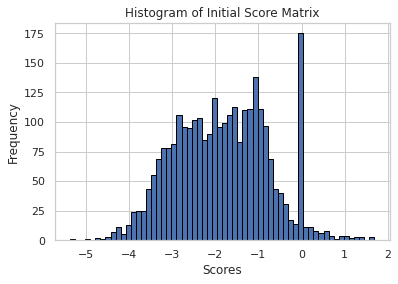

In [24]:
import matplotlib.pyplot as plt

# Assuming initial_score_matrix is already defined and is a NumPy array
# Flatten the matrix to get a 1D array
#flattened_scores = initial_score_matrix.flatten()/optimizer.wt_score
flattened_scores = initial_score_matrix.flatten()
# Plot the histogram with 60 bins
plt.hist(flattened_scores, bins=60, edgecolor='black')

# Add title and labels
plt.title('Histogram of Initial Score Matrix')
plt.xlabel('Scores')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 2.19e+03 effective entries: 120 sites, 19 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 520 sequences. Finished iter 0 with mean ml score of -4.38, and std. dev. 1.24.
Starting iter 1: processing 520 sequences, using T = 1.4.
Joint probability has 2.17e+03 effective entries: 121 sites, 19.1 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 1040 sequences. Finished iter 1 with mean ml score of -4.28, and std. dev. 1.16.
Starting iter 2: processing 520 sequences, using T = 1.2.
Joint probability has 2.19e+03 effective entries: 123 sites, 19 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 1560 sequences. Finished iter 2 with mean ml score of -4.39, and std. dev. 1.26.
Starting iter 3: processing 520 sequences, using T = 1.1.
Joint probability has 2.16e+0

In [ ]:
optimizer.plot_scores()

In [22]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_seq2fitness_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

In [7]:
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
torch.cuda.empty_cache()
gc.collect()

Elapsed time: 618.41 seconds


2426

#### K=5

In [ ]:
NUM_MUT = 5
NUM_ITER = 200


model_path = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': 4.0, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")



# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -0.677.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -0.9143, std dev: 1.0934. To normalize scores.
phase transition threshold is 4.0
Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 2.19e+03 effective entr

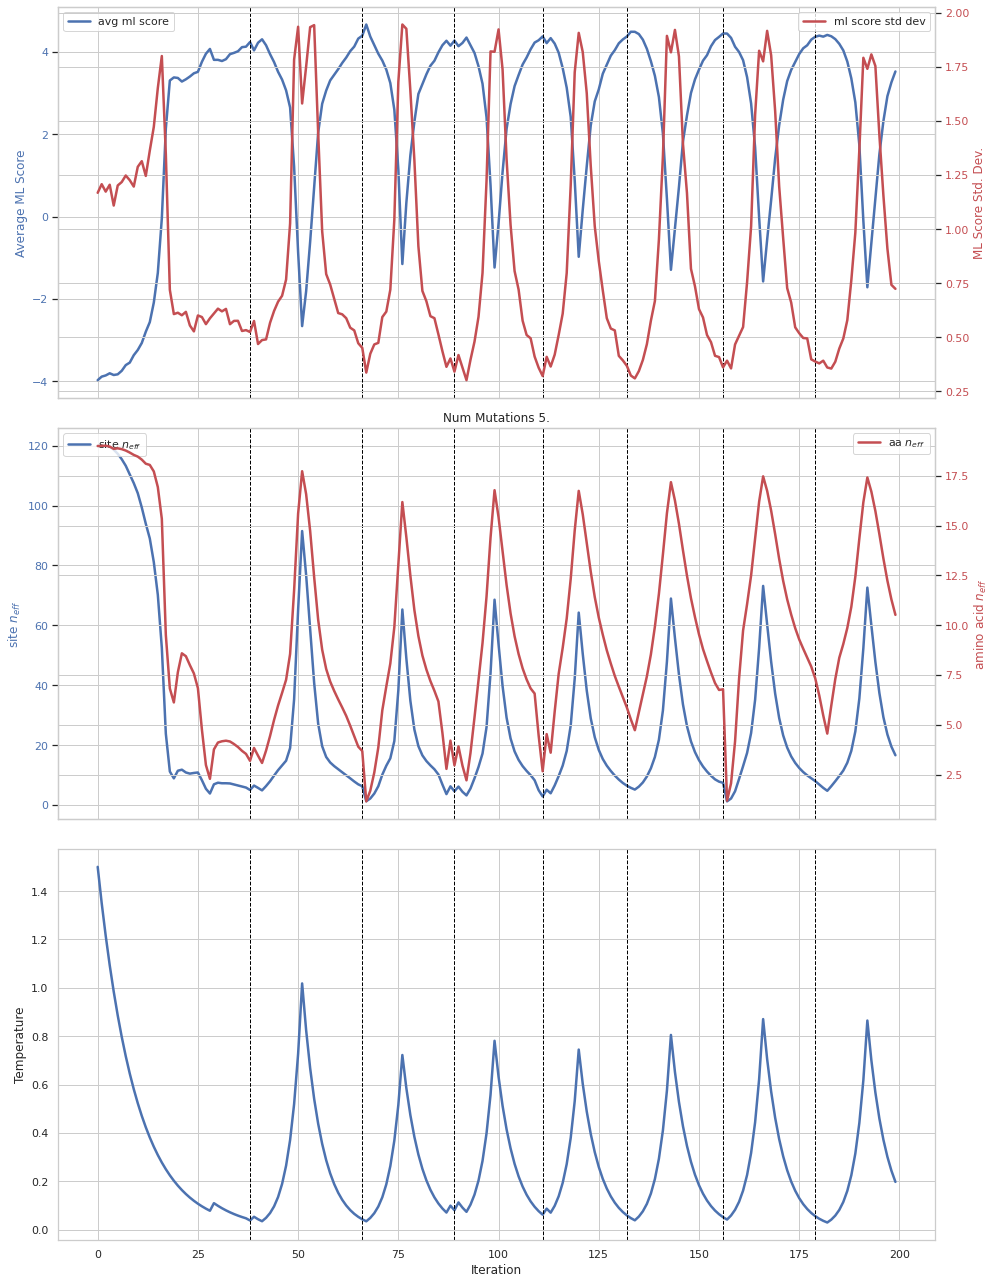

37
37


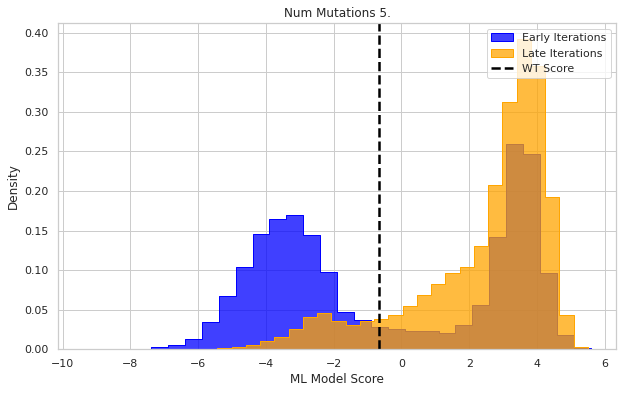

In [6]:
optimizer.plot_scores()

In [7]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_seq2fitness_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K = 4

In [ ]:
NUM_MUT = 4
NUM_ITER = 200
THRESHOLD = 3.5


model_path = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")



# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -0.677.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -0.9143, std dev: 1.0934. To normalize scores.
phase transition threshold is 3.5
Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 2.19e+03 effective entr

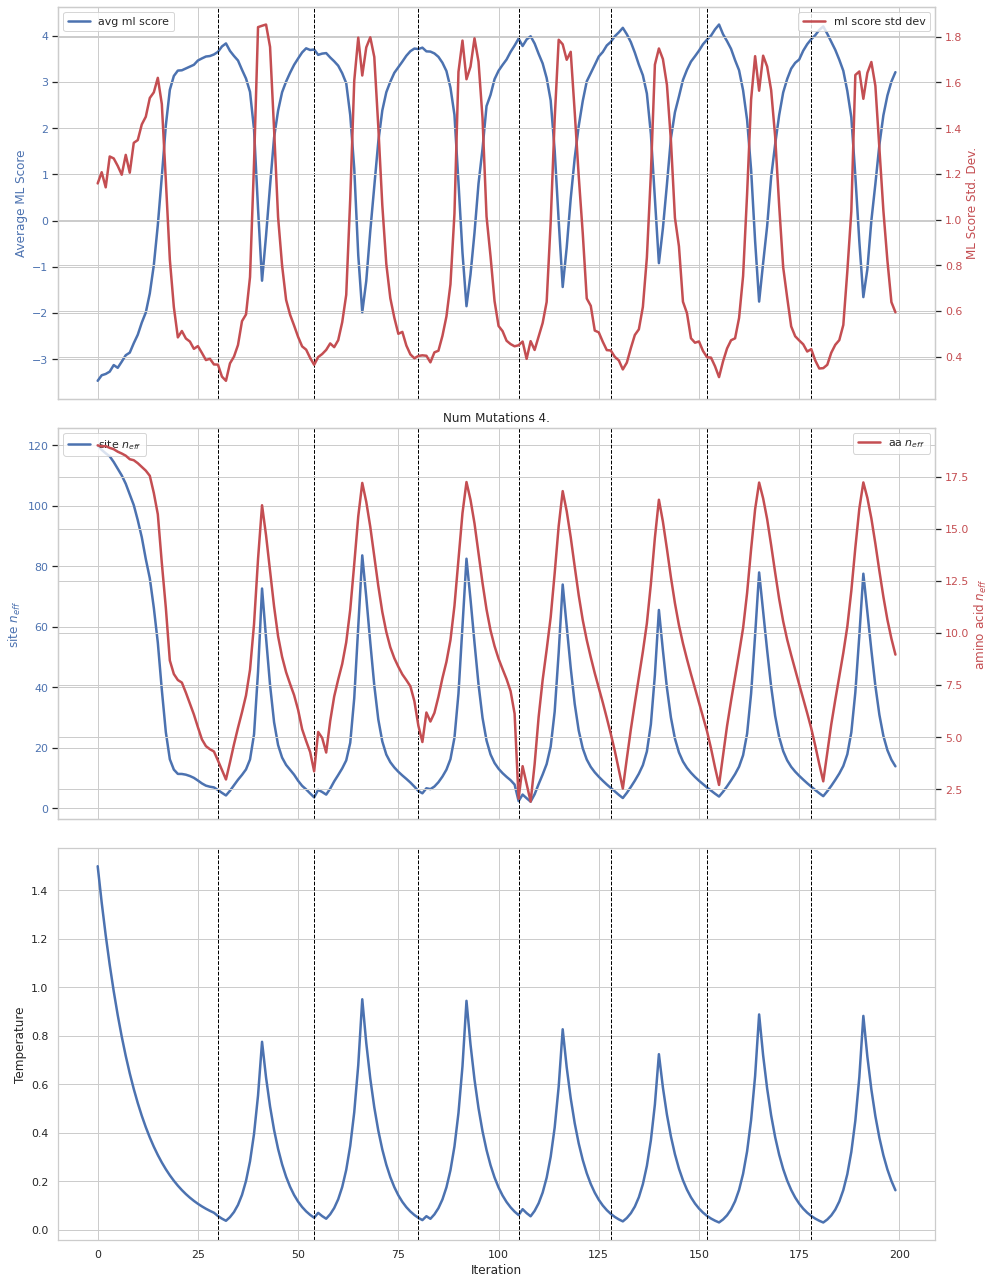

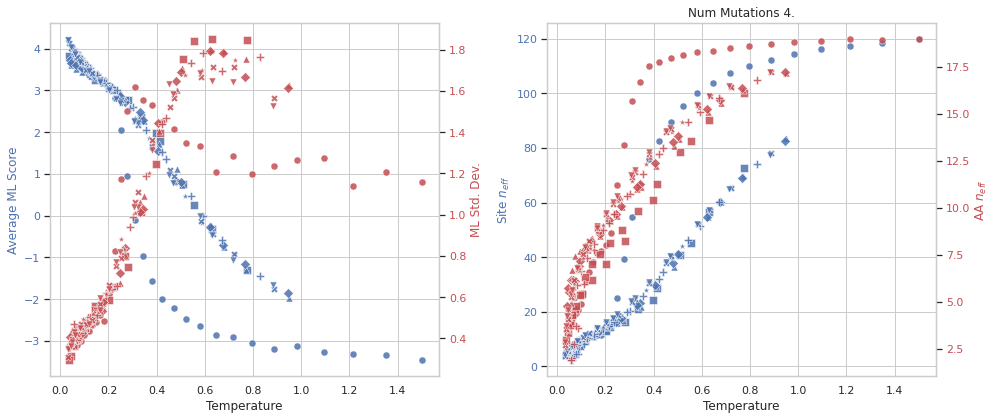

29
29


In [11]:
optimizer.plot_scores()

In [12]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_seq2fitness_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K = 3

In [ ]:
NUM_MUT = 3
NUM_ITER = 200
THRESHOLD = 3.0


model_path = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 0,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}





import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")



# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -0.677.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -0.9143, std dev: 1.0934. To normalize scores.
phase transition threshold is 3.0

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 2.19e+03 effective ent

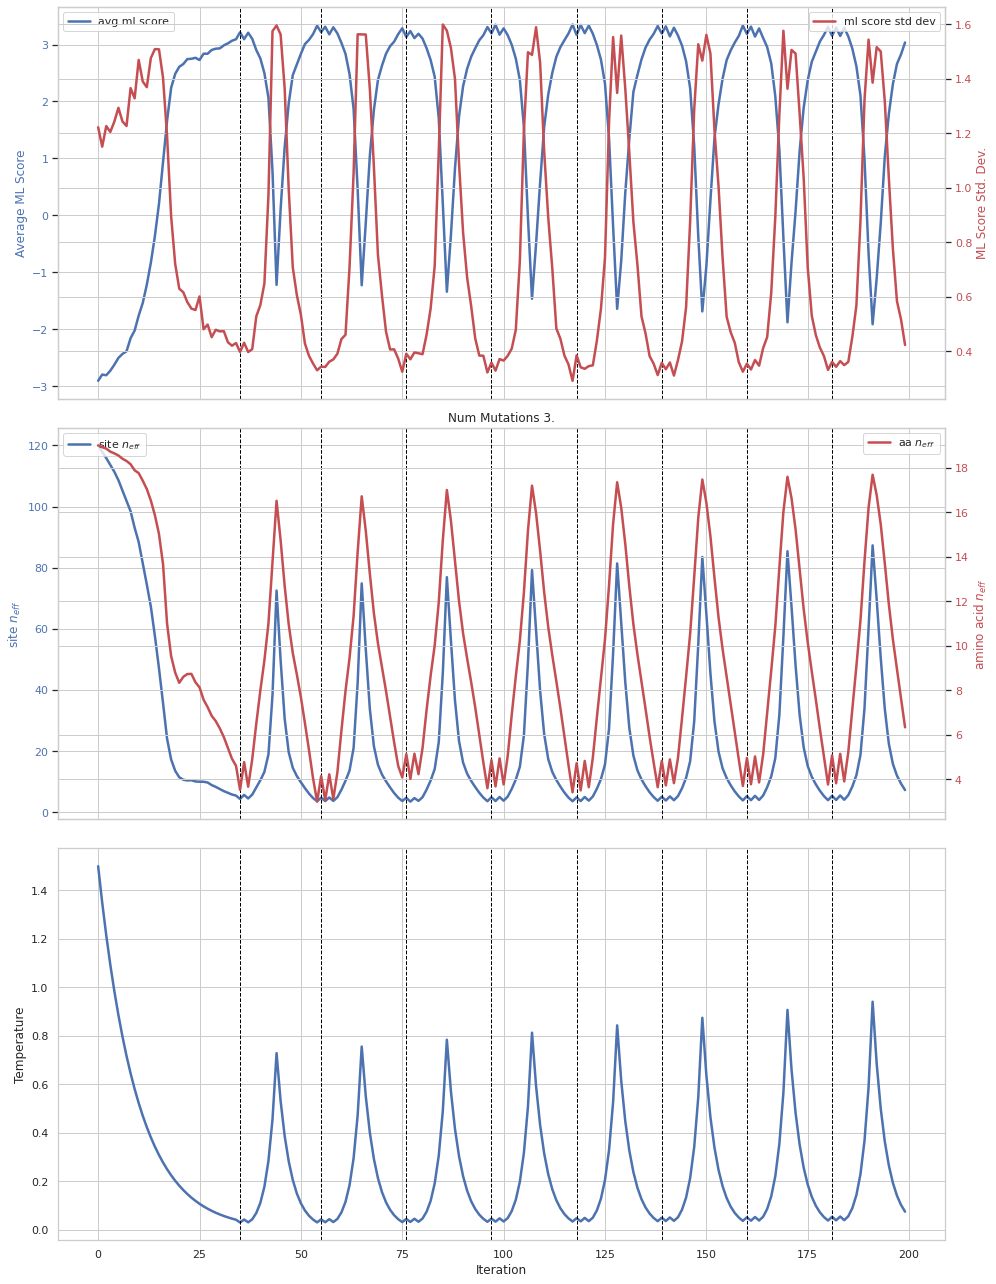

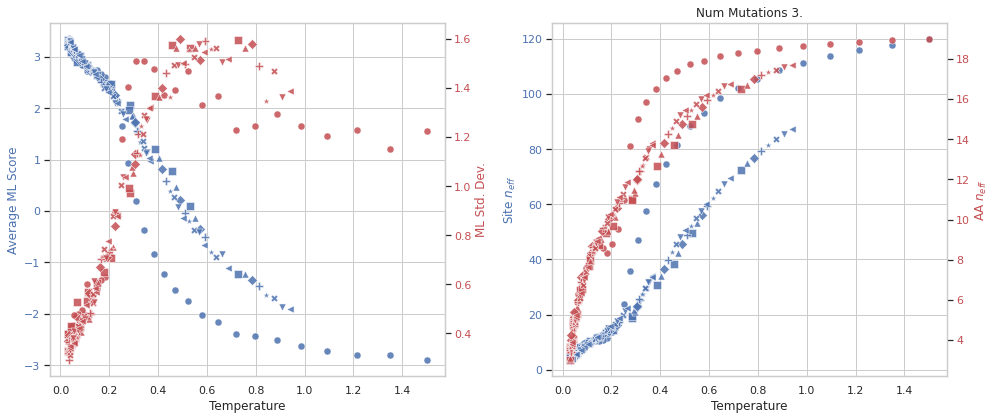

34
34


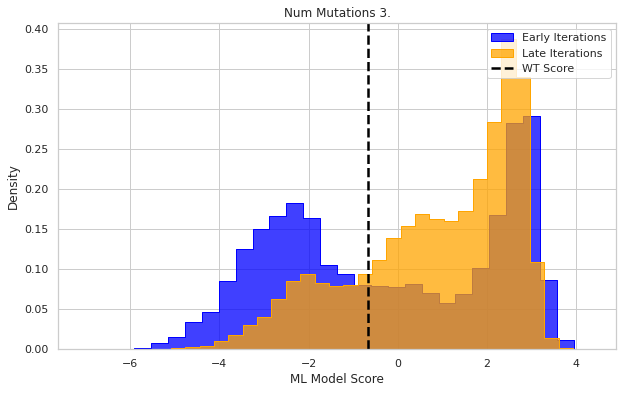

In [8]:
optimizer.plot_scores()

In [9]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_seq2fitness_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=2

In [ ]:
NUM_MUT = 2
NUM_ITER = 200
THRESHOLD = 2.0


model_path = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 0,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}





import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")



# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -0.677.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -0.9143, std dev: 1.0934. To normalize scores.
phase transition threshold is 2.0

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 2.19e+03 effective ent

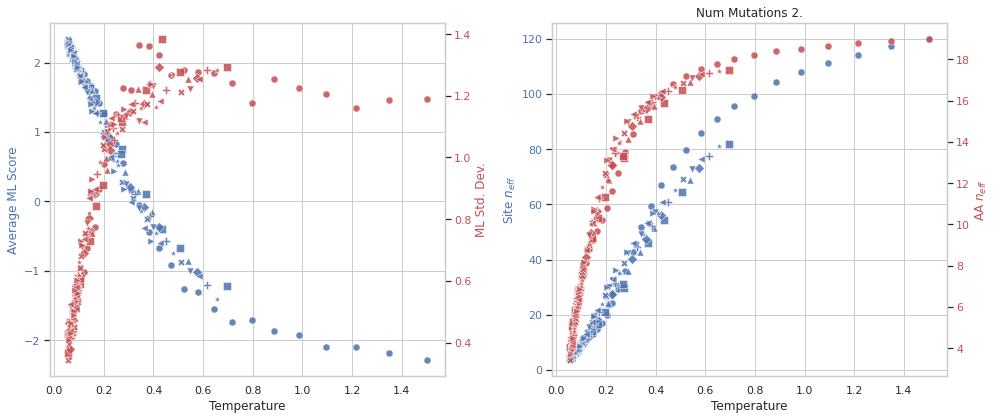

30
30


In [17]:
optimizer.plot_scores()

In [18]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_seq2fitness_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=2to6

In [ ]:
NUM_MUT = 6
NUM_ITER = 200
THRESHOLD = 3.0


model_path = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 0,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1], # known bad sites that we should not sample sequences from
    'sample_variety_of_mutation_numbers': True
}





import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")



# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -0.677.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -0.9143, std dev: 1.0934. To normalize scores.
phase transition threshold is 3.0

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 2.19e+03 effective ent

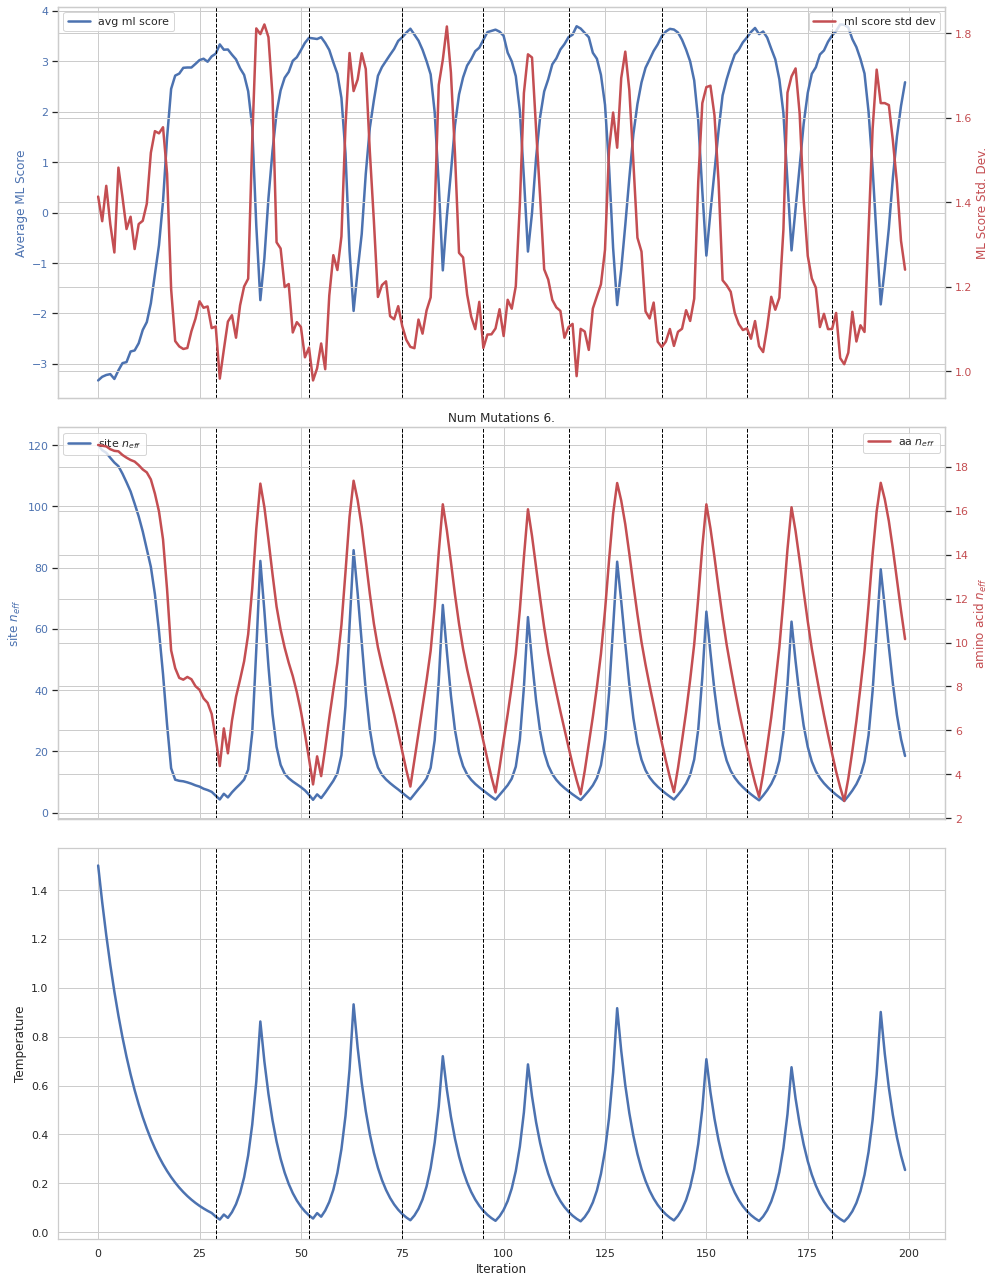

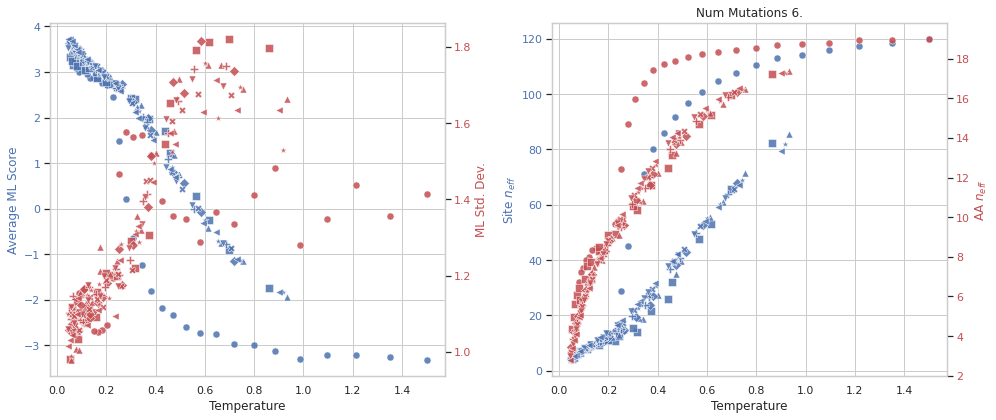

28
28


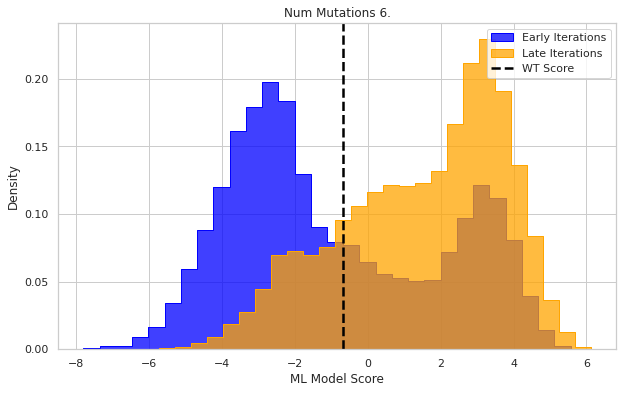

In [22]:
optimizer.plot_scores()

In [23]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_seq2fitness_results_num_mutations_2to6_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)